In [1]:
import numpy as np
import matplotlib.pylab as plot
from astropy.io import ascii,fits
from scipy import interpolate
import grb_catalogs
from BurstCube.LocSim.Detector import *
from BurstCube.LocSim.Spacecraft import *
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.optimize import curve_fit
from astropy.table import Table
import pandas as pd
import healpy as hp

In [2]:
def loginterpol(x,y,x1):

    f=interpolate.interp1d(np.log10(x),np.log10(y),bounds_error=False,fill_value="extrapolate",kind='linear')
    y1=10**f(np.log10(x1))

    return y1

In [3]:
#function to match GRBs in the Trigger catalog to those in the grb catalog so that we can create an array of the grbs in both
#We will use the trigger timescale found in the trigger catalog 
def match_catalogs_name(name1,name2):

    ind_dict = dict((q,e) for e,q in enumerate(name1))
    inter = set(ind_dict).intersection(name2)
    m1 = [ind_dict[element] for element in inter]
    print(np.shape(m1))
    
    ind_dict = dict((q,e) for e,q in enumerate(name2))
    inter = set(ind_dict).intersection(name1)
    m2 = [ind_dict[element] for element in inter]
    print(np.shape(m2))
    
    return m1,m2

In [4]:
## read in the GBM Aeff
myBCgitdir='/Users/jracusin/BurstCube/gitrep/Users/jracusin/'
aeff_gbm = np.genfromtxt(myBCgitdir+'gbm_effective_area.dat',skip_header=2,names=('energy', 'aeff'))

In [17]:
## read in BurstCube Aeff for various BC configurations
file=myBCgitdir+'BC_eff_area_curves.ecsv'
bcaeffs=ascii.read(file,format='ecsv')
#dir='/Users/jracusin/GBM/'
#read in GBM Trigger Catalog
trigfit=fits.open(myBCgitdir+'gbmtrigcat.fits')
trig=trigfit[1].data

#read in GBM Burst Catalog
gbmfit=fits.open(myBCgitdir+'gbmgrbcat.fits')
gbm=gbmfit[1].data
print gbm.columns

#creating array of grbs that are found in both catalogs
m1, m2 = match_catalogs_name(trig['NAME'],gbm['NAME'])

#defining our two samples of bursts that are found in both catalogs so that we can utilize them further down
trigbursts = trig[m1]
gbmbursts = gbm[m2]
print(gbmbursts['NAME'])

ColDefs(
    name = 'NAME'; format = 'A12'; start = 1
    name = 'RA'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 14
    name = 'DEC'; format = 'F8.0'; unit = 'DEGREE'; disp = 'F8.4'; start = 23
    name = 'TRIGGER_TIME'; format = 'F15.0'; unit = 'MJD'; disp = 'F15.7'; start = 32
    name = 'T90'; format = 'F8.0'; unit = 'S'; disp = 'F8.3'; start = 48
    name = 'T90_ERROR'; format = 'F9.0'; unit = 'S'; disp = 'F9.3'; start = 57
    name = 'T90_START'; format = 'F9.0'; unit = 'S'; disp = 'F9.3'; start = 67
    name = 'FLUENCE'; format = 'F10.0'; unit = 'ERG/CM^2'; disp = 'E10.4'; start = 77
    name = 'FLUENCE_ERROR'; format = 'F13.0'; unit = 'ERG/CM^2'; disp = 'E13.4'; start = 88
    name = 'FLUX_1024'; format = 'F9.0'; unit = 'PHOTON/CM^2/S'; disp = 'F9.4'; start = 102
    name = 'FLUX_1024_ERROR'; format = 'F15.0'; unit = 'PHOTON/CM^2/S'; disp = 'F15.4'; start = 112
    name = 'FLUX_1024_TIME'; format = 'F14.0'; unit = 'S'; disp = 'F14.3'; start = 128
    name = 'FLUX_

In [6]:
## separate GBM short & long GRBs
w=np.where(gbmbursts['FLUX_1024']>0)
gbmbursts=gbmbursts[w]
s=np.where((gbmbursts['T90'] <= 2.)&((gbmbursts['PFLX_SPECTRUM_STOP']-gbmbursts['PFLX_SPECTRUM_START'])>0))[0]
l=np.where(gbmbursts['T90'] > 2.)[0]
m=np.where(gbmbursts['PFLX_BEST_FITTING_MODEL'][s] == ' ')

In [32]:
## grab short GRBs with peak spectral info & plot all of the Aeff curves
w=np.where((bcaeffs['diameter']==90) & (bcaeffs['height']==19) )
#print bcaeffs[w]
bcaeffs=bcaeffs[w]
print bcaeffs
bceng=bcaeffs['keV']
BCaeffs=bcaeffs
#aeff_gbm = getGBMdata(myBCgitdir+'gbm_effective_area.dat')

diameter height  az  ze   keV     aeff  aeff_eres aeff_eres_modfrac
-------- ------ --- --- ------- ------- --------- -----------------
    90.0   19.0 0.0 0.0    50.0 56.0057     47.28           54.9864
    90.0   19.0 0.0 0.0 75.1462 60.1213   54.4458           58.8948
    90.0   19.0 0.0 0.0 112.939 61.7605    57.709           60.0127
    90.0   19.0 0.0 0.0 169.739 61.7576    57.484           59.5096
    90.0   19.0 0.0 0.0 255.105 54.1984   46.5997           47.9276
    90.0   19.0 0.0 0.0 383.404 42.0248   28.8543           29.4006
    90.0   19.0 0.0 0.0 576.227 33.3321   16.7727            17.036
    90.0   19.0 0.0 0.0 866.025 27.8825   10.3667           20.7725
    90.0   19.0 0.0 0.0 1301.57 22.6889   6.15776           12.3291
    90.0   19.0 0.0 0.0 1956.16 19.9883   4.07161           8.16321
    90.0   19.0 0.0 0.0 2939.97 18.7626   2.57235           5.15783
    90.0   19.0 0.0 0.0 4418.55 18.1448   1.48243           2.97575
    90.0   19.0 0.0 0.0 6640.74 18.8384  0.83077

In [46]:
mo=gbmbursts['PFLX_BEST_FITTING_MODEL']
gbmcr=np.zeros(len(gbmbursts))
bccr=np.zeros(len(gbmbursts))
pf=np.zeros(len(gbmbursts)) 
outE=np.logspace(np.log10(30),np.log10(1000),100) # returns numbers spaced evenly on a log scale
nsims=1
E=np.array(BCaeffs['keV'])
AeffBC=loginterpol(E,BCaeffs['aeff_eres_modfrac'],outE)
AeffGBM=loginterpol(aeff_gbm['energy'],aeff_gbm['aeff'],outE) #eng[w[j]+1:w[j+1]+1])       
Aratio=(AeffBC/AeffGBM)
for i in range(len(s)):
    for j in range(nsims):
    
        # this should give us an array of the maximum observed photon flux for GBM
        if mo[i]=='PFLX_PLAW':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][i]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][i])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][i]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][i]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_PLAW_AMPL'][s[i]]*grb_catalogs.pl(outE,gbmbursts['PFLX_PLAW_INDEX'][s[i]])*AeffGBM*Aratio,outE)
    
        if mo[i]=='PFLX_COMP':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][i]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][i],gbmbursts['PFLX_COMP_EPEAK'][i])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][i]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][i],gbmbursts['PFLX_COMP_EPEAK'][i]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_COMP_AMPL'][s[i]]*grb_catalogs.comp(outE,gbmbursts['PFLX_COMP_INDEX'][s[i]],gbmbursts['PFLX_COMP_EPEAK'][s[i]])*AeffGBM*Aratio,outE)

        if mo[i]=='PFLX_BAND':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][i]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][i],gbmbursts['PFLX_BAND_EPEAK'][i],gbmbursts['PFLX_BAND_BETA'][i])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][i]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][i],gbmbursts['PFLX_BAND_EPEAK'][i],gbmbursts['PFLX_BAND_BETA'][i]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_BAND_AMPL'][s[i]]*grb_catalogs.band(outE,gbmbursts['PFLX_BAND_ALPHA'][s[i]],gbmbursts['PFLX_BAND_EPEAK'][s[i]],gbmbursts['PFLX_BAND_BETA'][s[i]])*AeffGBM*Aratio,outE)

        if mo[i]=='PFLX_SBPL':
            gbmcr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][i]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][i],gbmbursts['PFLX_SBPL_BRKEN'][i],gbm['PFLX_SBPL_INDX2'][i])*AeffGBM,outE)
            pf[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][i]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][i],gbmbursts['PFLX_SBPL_BRKEN'][i],gbm['PFLX_SBPL_INDX2'][i]),outE)
            bccr[i]=np.trapz(gbmbursts['PFLX_SBPL_AMPL'][s[i]]*grb_catalogs.sbpl(outE,gbmbursts['PFLX_SBPL_INDX1'][s[i]],gbmbursts['PFLX_SBPL_BRKEN'][s[i]],gbm['PFLX_SBPL_INDX2'][s[i]])*AeffGBM*Aratio,outE)


66.35636934434112


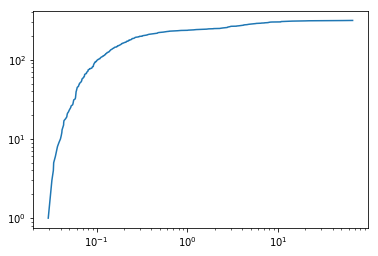

In [47]:
w=np.where(pf>0)[0]
pflx_dur=gbmbursts[w]['PFLX_SPECTRUM_STOP']-gbmbursts[w]['PFLX_SPECTRUM_START']
pf64=pf[w]/pflx_dur*0.064
so=np.argsort(pf64)
c=np.cumsum(np.ones(len(w)))
plot.plot(pf64[so],c)
plot.xscale('log')
plot.yscale('log')
#plot.xlim(0,80)
#plot.ylim(1,2500)
print max(pf64)


26823585.631116018
1525.472475647615


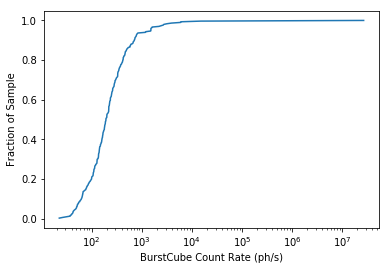

In [49]:
w=np.where(bccr>0)[0]
pflx_dur=gbmbursts[w]['PFLX_SPECTRUM_STOP']-gbmbursts[w]['PFLX_SPECTRUM_START']
bccr64=bccr[w]#/pflx_dur*0.064
so=np.argsort(bccr64)
c=np.cumsum(np.ones(len(w)))
plot.plot(bccr64[so],c/max(c))
plot.xscale('log')
#plot.yscale('log')
plot.xlabel('BurstCube Count Rate (ph/s)')
plot.ylabel('Fraction of Sample')
#plot.xlim(0,80)
#plot.ylim(1,2500)
print max(bccr64)
print bccr64[so[int(0.95*len(so))]]

In [29]:
print Aratio

[1.65360456 1.3931848  1.2028048  1.04072825 0.88980134 0.75630935
 0.69267994 0.64126    0.59365714 0.55543094 0.53475306 0.51484498
 0.49567805 0.47722467 0.47168308 0.46641424 0.46120426 0.45605247
 0.45127103 0.44689398 0.44255939 0.43826684 0.43401593 0.42980624
 0.42563739 0.46092925 0.4918794  0.47770766 0.46394422 0.45057732
 0.43759555 0.43323311 0.43468157 0.43613487 0.43759303 0.43905606
 0.44052399 0.44199682 0.44347458 0.44495728 0.44644494 0.44793757
 0.44943519 0.45093781 0.45079322 0.44973264 0.44867456 0.44761897
 0.44873017 0.45017353 0.45162153 0.45307419 0.45453153 0.45474208
 0.45478905 0.45483603 0.454883   0.45492999 0.4611368  0.47451614
 0.48828366 0.50095145 0.50338651 0.50583342 0.50829222 0.51076297
 0.51324573 0.51574056 0.51824752 0.52076666 0.51735602 0.50396067
 0.49091215 0.47820148 0.46581992 0.45375894 0.44201024 0.42814547
 0.41450833 0.39971784 0.38447532 0.36981404 0.35571184 0.34214741
 0.32910023 0.31655058 0.30447949 0.29286871 0.30280869 0.3170

2041.3049999999998


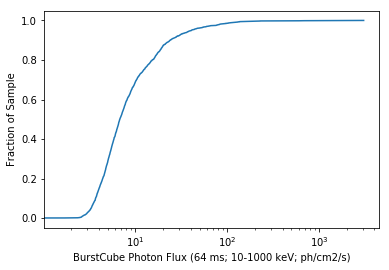

In [44]:
flux64=gbmbursts['flux_64']
so=np.argsort(flux64)
c=np.cumsum(np.ones(len(so)))
plot.plot(flux64[so],c/max(c))
plot.xscale('log')
#plot.yscale('log')
plot.xlabel('BurstCube Photon Flux (64 ms; 10-1000 keV; ph/cm2/s)')
plot.ylabel('Fraction of Sample')
print flux64[so[int(0.95*len(so))]]*50#*0.064

[1.024 1.024 1.024 1.024 1.024 0.064 1.024 1.024 1.024 1.024 1.024 1.024
 1.024 1.024 0.064 1.024 1.024 1.03  0.064 1.024 1.024 1.024 1.024 1.024
 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024
 1.024 0.064 1.024 1.024 1.024 1.024 1.024 1.024 0.064 1.024 0.064 1.024
 1.024 0.064 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 0.064
 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.03  1.024 0.064 1.024
 0.064 1.024 1.024 1.024 1.024 1.024 1.024 0.064 1.024 1.024 1.024 0.064
 1.024 0.064 1.024 1.024 1.024 0.064 1.024 1.024 1.024 1.024 1.024 1.024
 1.024 1.024 0.064 0.064 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024
 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 1.024 0.064
 0.064 1.024 1.024 1.024 1.02  1.024 1.024 1.024 0.064 1.024 1.024 1.024
 1.024 1.024 1.024 1.024 1.024 0.064 0.064 1.024 0.064 1.024 1.024 1.024
 1.024 1.024 1.024 0.064 1.024 1.024 1.024 1.024 0.064 1.024 1.024 0.064
 1.024 1.024 1.024 1.024 0.064 1.024 1.024 1.024 1.

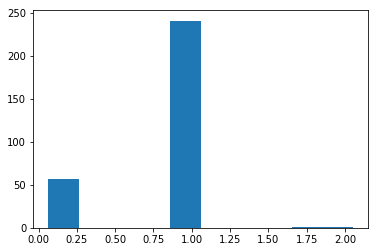

In [54]:
plot.hist(pflx_dur,bins=10)
print pflx_dur